# Radar FMCW and CSM algorithms

This notebook shows a naive (didactically intuitive) implementation of following algorithms:

- FMCW (Frequency Modulated Continuous Wave)
- CSM (Chirp Sequence Modulation)

Both algorithms are used for range and velocity measurements in automated/assisted driving domain.

## Introduction

### Doppler

An electromagnetic wave 

\begin{align}
w(t) &= a_t cos(2\pi f_0t)
\end{align}

reflected on a moving object with velocity $v$ leads to a new wave:

\begin{align}
u_r(t) &= a_r \text{cos}(2\pi (f_0 - f_{d}) t + \phi_r + \phi_t) \\
\end{align}

In order to understand what signal the algorithms operate on we have to take a closer look at the inner workings of a continuous wave radar (simplified view):

![cw-radar](cw-radar.png)

[Source](https://en.wikipedia.org/wiki/Continuous-wave_radar#/media/File:Bsp2_CW-Radar.EN.png)

### Antennas

The CW-RADAR has one transmitting antenna and at least one receiving antenna. The former emits a continuous radio wave, that's different to pulse-based RADAR systems. The receiving antenna transforms the reflected waves from the object of interests and converts the signal into eletrical domain (voltage).

Automotive long range radars use a $77.7\text{GHz}$ base frequency.

### RF-Generator

The RF-generator is a module which dynamically generates a sine voltage with a particular frequency. Since both methods presented here modulate (alter) the frequency of the tramitted radio wave, the generator is an essential part in the system.

### Mixer

The mixer is the most important component in the system described here. It allows us to measure the frequency change introduced by the moving object we are going to detect. We apply to the antenna the voltage $u_t(t)$ and receive the voltage $u_r(t)$.

\begin{align}
u_t(t) &= A_t \text{cos}(2\pi f_0 t+\phi_t) \\
u_r(t) &= A_r \text{cos}(2\pi (f_0 - f_{d}) t + \phi_r)
\end{align}

With Doppler frequency

\begin{align}
f_{d} = \frac{2v}{\lambda} = \frac{2 \dot r}{\lambda} = \frac{2 f_0 \dot r}{c}
\end{align}

Given base wavelength $\lambda$ and target velocity $v=\dot r$.

Theoretically, if we could sample $f_0 - f_{d} \approx 77.7GHz$ and we were done. But high frequency AD converters (according to Nyquist $\geq 2f_0 \approx 145GHz$ is required) are techinically expensive and the change introduced by $f_d$ is very small to detect changes. That's why we need the mixer to get rid of the high frequency $f_0$ and work only on the $f_d$. 

The mixer multiplies both signals, corresponding to trigonometry relations:

\begin{align}
\text{cos}(x)\text{cos}(y) = \frac{1}{2} [ \text{cos}(x-y) + \text{cos}(x+y)]
\end{align}

Applied to $u_t(t)$ and $u_r(t)$:

\begin{align}
u_t(t)u_r(t) &= \frac{A_t A_r}{2} [ \text{cos}(2\pi f_0 t+\phi_t-2\pi (f_0 - f_{d}) t - \phi_r) + \text{cos}(2\pi f_0 t+\phi_t+ 2\pi (f_0 - f_{d}) t + \phi_r)] \\
&= \frac{A_t A_r}{2} [ \text{cos}(2\pi f_{d} t + \phi_t - \phi_r) + \text{cos}(2\pi f_0 t+\phi_t + 2\pi (f_0- f_{d}) t + \phi_r)] \\
&= \frac{A_t A_r}{2} [ \text{cos}(2\pi f_{d} t + \phi_t - \phi_r) + \text{cos}(2\pi \underbrace{2 f_0}_{\text{2x 77GHz}} t - 2\pi f_{d}t + \phi_t + \phi_r)] \\
\end{align}

The product of both signals equals to a sum of two waves, the first, only dependent on the doppler frequency (which is velocity dependent) and the second a very high frequency signal (144 GHz) which we filter out with the low pass filter:

\begin{align}
u_{It,r}(t) = \frac{A_t A_r}{2} \text{cos}(2\pi f_{d} t + \phi_t - \phi_r)
\end{align}

After the AD converter we could sample $u_{It,r}(t)$ and measure the (unsigned) velocity. The index $I$ means in-phase. We later will introduce an other index in order to extract the sign of the velocity (approaching vs. departing).

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fftpack import fft

Constant for velocity of light within the air:

In [8]:
c = 299792458

## FCMW

Instead of sending with one frequency, we will alter $f_0$ over time:

\begin{align}
u_t(t) &= A_t \text{cos}(2\pi f_t t+\phi_t)
\end{align}

with 

\begin{align}
f_t = f_t(t) = f_0 + m_w(t-t_0)
\end{align}

In [9]:
f_0 = 77.7*1e9 # 77.7GHz

phi_t = 0
A_t = 1
f_ramp = 425*1e6 #Hz
T_ramp = 0.010
m_w = f_ramp/T_ramp

In [10]:
def f_t(t):
    return f_0 + m_w*(t % T_ramp)

In [11]:
def u_t(t):
    f_b = f_t(t)
    return A_t*np.cos(2*np.pi*f_b*t + phi_t)

The received signal depends on both the range $r$ and the velocity $v$:

\begin{align}
u_r(t) &= A_r \text{cos}(2\pi f_r t+\phi_r)
\end{align}

with 

\begin{align}
f_r = f_r(t) = f_0 + m_w(t- \frac{2r}{c}-t_0) - \frac{2vf_0}{c}
\end{align}

In [12]:
v = 50/3.6 # 50km/h
r = 100 # 100m distance

In [13]:
def f_r(t):
    return f_0 + m_w*(t % T_ramp - 2*r/c) - 2*v*f_0/c

In [14]:
t = np.arange(0, 2*T_ramp, 1e-8)

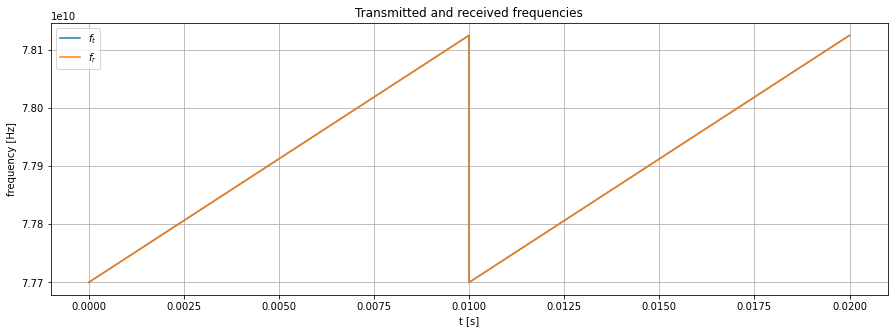

In [15]:
plt.figure(figsize=(15,5))
plt.plot(t, f_t(t), label="$f_t$")
plt.plot(t, f_r(t), label="$f_r$")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("frequency [Hz]")
plt.title("Transmitted and received frequencies")
plt.grid();

Because we don't see any difference let's zoom in 

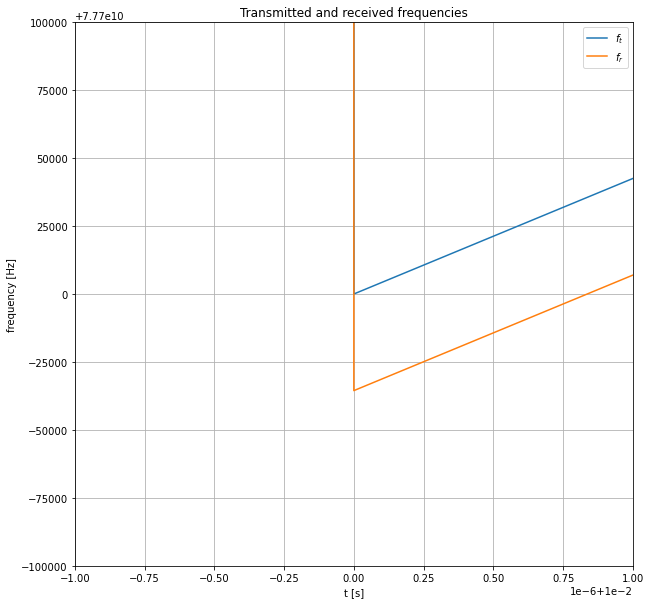

In [16]:
t_op = T_ramp
plt.figure(figsize=(10,10))
plt.plot(t, f_t(t), label="$f_t$")
plt.plot(t, f_r(t), label="$f_r$")
plt.legend()
plt.xlim([t_op-T_ramp/10000, t_op+T_ramp/10000])
plt.ylim([f_0-100e3, f_0+100e3])
plt.xlabel("t [s]")
plt.ylabel("frequency [Hz]")
plt.title("Transmitted and received frequencies")
plt.grid();

If we could measure $\Delta f$ directly we could derive $r$ and $v$:

\begin{align}
\Delta f = f_t-f_r = \frac{2m_w}{c}r + \frac{2 f_0}{c}\dot r
\end{align}

There is just one problem. We have one equation but two unknowns. The solution for that problem is to have a second ramp with a different $m_w$:

\begin{align}
f_t(t) = \{\begin{array}{lr}
        f_0 + m_{w,1}(t-t_0), & \text{for } 0 \leq t < T_{r,1}\\
        f_0 + m_w T_{r,1} + m_{w,2}(t-t_0), & \text{for } T_{r,1} \leq t < T_{r,1}+T_{r,2}\
        \end{array}
\end{align}

Define and implement both waveforms:

In [17]:
T_ramp1 = T_ramp*0.7
T_ramp2 = T_ramp*0.3
m_w1 = f_ramp/T_ramp1
m_w2 = -f_ramp/T_ramp2

In [18]:
def f_t(t):
    r1 = f_0 + m_w1*(t % (T_ramp1+T_ramp2))
    r1[(t%(T_ramp1+T_ramp2)) > T_ramp1] = 0
    
    r2 = f_0 + m_w1*T_ramp1 + m_w2*( (t-T_ramp1) % (T_ramp1+T_ramp2))
    r2[(t%(T_ramp1+T_ramp2)) <= T_ramp1] = 0
    
    return r1+r2

In [19]:
def f_r(t):
    r1 = f_0 + m_w1*(t % (T_ramp1+T_ramp2) - 2*r/c) - 2*v*f_0/c
    r1[(t%(T_ramp1+T_ramp2)) > T_ramp1] = 0
    
    r2 = f_0 + m_w1*T_ramp1 + m_w2*( (t-T_ramp1) % (T_ramp1+T_ramp2) - 2*r/c) - 2*v*f_0/c
    r2[(t%(T_ramp1+T_ramp2)) <= T_ramp1] = 0
    return r1+r2

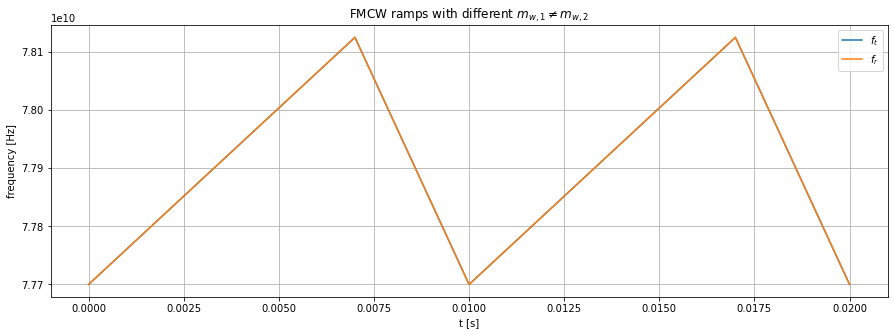

In [20]:
t = np.arange(0, 2*T_ramp, 1e-7)
plt.figure(figsize=(15,5))
plt.plot(t, f_t(t), label="$f_t$")
plt.plot(t, f_r(t), label="$f_r$")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("frequency [Hz]")
plt.title("FMCW ramps with different $m_{w,1} \\neq m_{w,2}$")
plt.grid();

Zoom in again:

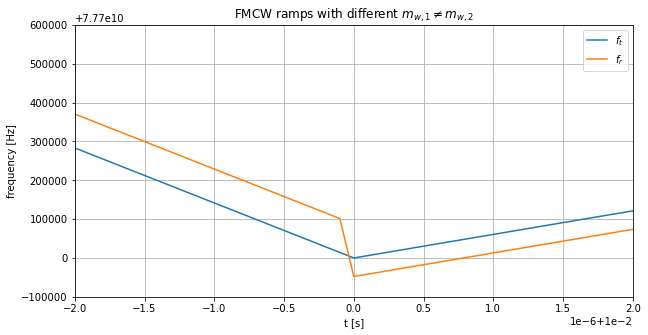

In [21]:
t_op = T_ramp
plt.figure(figsize=(10,5))
plt.plot(t, f_t(t), label="$f_t$")
plt.plot(t, f_r(t), label="$f_r$")
plt.legend()
plt.xlim([t_op-T_ramp/5000, t_op+T_ramp/5000])
plt.ylim([f_0-100e3, f_0+600e3])
plt.xlabel("t [s]")
plt.ylabel("frequency [Hz]")
plt.title("FMCW ramps with different $m_{w,1} \\neq m_{w,2}$")
plt.grid();

Now we have two equations:

\begin{align}
\Delta f_1 = \frac{2m_{w,1}}{c}r + \frac{2 f_0}{c}\dot r \\
\Delta f_2 = \frac{2m_{w,2}}{c}r + \frac{2 f_0}{c}\dot r
\end{align}

Solving the equation system:

In [22]:
t_f1 = np.asarray([T_ramp*0.1]) # beginning of rising ramp
t_f2 = np.asarray([T_ramp*0.8])  # beginning of falling ramp
delta_f_1 = f_t(t_f1) - f_r(t_f1)
delta_f_2 = f_t(t_f2) - f_r(t_f2)

In [23]:
A = np.asarray([[2*m_w1/c, 2*f_0/c], [2*m_w2/c, 2*f_0/c]])
Y = np.asarray([delta_f_1, delta_f_2])

In [24]:
x = np.linalg.solve(A, Y).flatten()
print("range r:", x[0])
print("velocity v:", x[1]*3.6)

range r: 99.99999999693145
velocity v: 49.99999988508472


As you could see we could successfully estimate the range and velocity.

**Note**: we get $\Delta f_i$ for free as a result of the FFT on the mixed and filtered signal 


\begin{align}
u_{It,r}(t) = \frac{A_t A_r}{2} \text{cos}(2\pi (f_t - f_r) t + \phi_t - \phi_r) = \frac{A_t A_r}{2} \text{cos}(2\pi \Delta f t + \phi_t - \phi_r)
\end{align}

In the FMCW chapter we did not address various problems like:

- multi target estimation (what happens if the FFT returns 2, 3, 4, ... major peaks?)
- angle estimation

We will solve the first problem in our second method.

## Chirp Sequence Modulation

This method is an extension of FMCW. Instead of sending one singe rising and falling frequency chirp we will repeat that process $n_r$ times in a sequence with chirp frequency $f_{chirp}$:

In [25]:
# chirp sequence frequency
f_chirp = 50*1e3 #Hz

# ramp frequency
f_r = 200*1e6 #Hz
T_r = 1/f_chirp # duration of one cycle
m_w = f_r/T_r

n_r = 150 # number of chirps
T_M = T_r*n_r

Because we perform analog sampling, we have to configure our AD-converter:

In [26]:
# sample settings
f_s = 50e6 #50 MHz
n_s = int(T_r*f_s)

Base frequency setup

In [27]:
f_0 = 77.7*1e9

# some helpful
w_0 = 2*np.pi*f_0
lambda_0 = c/f_0

In [28]:
def f_transmitted(t):
    return f_0 + m_w*(t%T_r)

In [29]:
def chirp(t):
    return np.cos(2*np.pi*(f_transmitted(t))*t)

Lets visualize the chirp sequence:

In [30]:
t = np.linspace(0, 3*T_r, int(1e6))

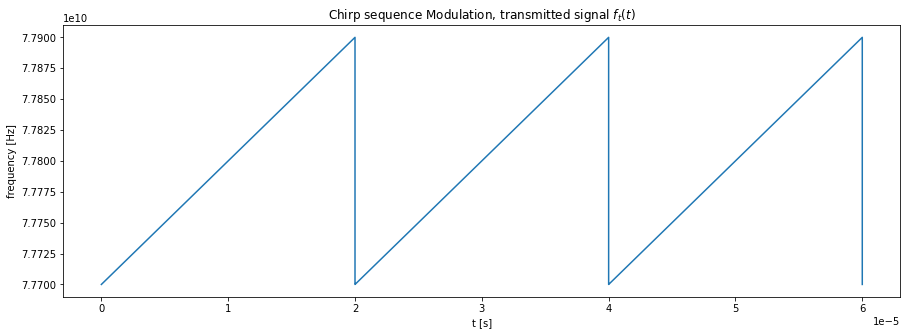

In [31]:
plt.figure(figsize=(15,5))
plt.plot(t, f_transmitted(t))
plt.xlabel("t [s]")
plt.ylabel("frequency [Hz]")
plt.title("Chirp sequence Modulation, transmitted signal $f_t(t)$");

### Reflector setup 

This is our target of interest

In [32]:
r_0 = 50 # initial distance
v_veh = 36/3.6 # velocity

In [33]:
def get_range(t):
    return r_0+v_veh*t

### Returned waveform

According to Eq. 17.46 in [1](https://www.springer.com/de/book/9783658057336) the returned waveform (after mixing and LF-filter) is:

\begin{align}
u_{It,r}(t) = \frac{A_t A_r}{2} \text{cos}\left(2\pi(\frac{2m_w}{c}r + \frac{2 f_0}{c}\dot r)t + \frac{4 \pi f_0 r}{c} + 2\pi(\frac{2 r}{c})^2m_w\right)
\end{align}

In [34]:
4*np.pi*100*f_0/c, 2*np.pi*(2*100/c)**2*m_w

(325694.31641129137, 27.963945936914552)

As you can see $2\pi(\frac{2 r}{c})^2m_w$ has not so much influence on the phase, so we ignore it:

\begin{align}
u_{It,r}(t) = \frac{A_t A_r}{2} \text{cos}\left(2\pi(\frac{2m_w}{c}r + \frac{2 f_0}{c}\dot r)t + \frac{4 \pi f_0 r}{c}\right)
\end{align}

In [35]:
def itr(t):
    r = get_range(t)
    w_itr = 2*f_0*v_veh/c + 2*m_w*r/c
    # we do t%T_r because the eq. above only valid within the ramp
    v = np.cos(2*np.pi*w_itr*(t%T_r) +2*r*2*np.pi*f_0/c)
    return v

We build up a table of $n_r × n_s$ where $n_r$ is the number of chirps (ramps) and $n_s$ is the number of samples within a chirp.

In [36]:
print(n_r, n_s)

150 1000


In [37]:
t_sample = np.linspace(0, T_M, n_r*n_s)

In [38]:
v_sample = itr(t_sample)

In [39]:
v_sample

array([ 0.90535311,  0.999836  ,  0.92013809, ...,  0.28771828,
       -0.12852771, -0.52235641])

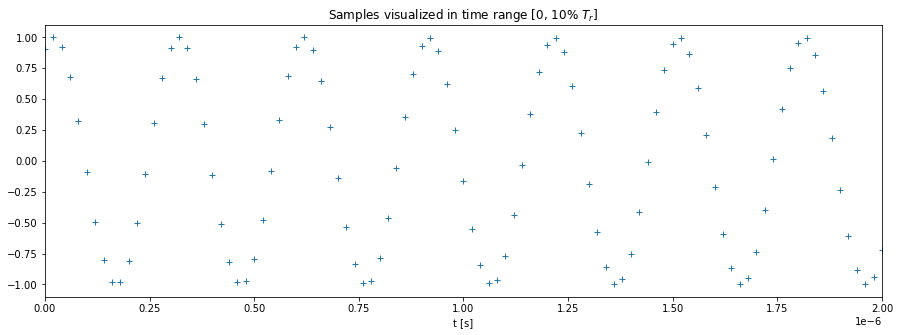

In [40]:
plt.figure(figsize=(15,5))
plt.plot(t_sample, v_sample, "+")
plt.xlim(0, 0.1*T_r)
plt.xlabel("t [s]")
plt.title("Samples visualized in time range [0, 10% $T_r$]");

We allocate memory for the sampling data

In [41]:
table = np.zeros((n_r, n_s))
print(table)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Fill in the values ...

In [42]:
for chirp_nr in range(n_r):
    table[chirp_nr, :] = v_sample[(chirp_nr*n_s):(n_s*(chirp_nr+1))]

print(table)

[[ 0.90535311  0.999836    0.92013809 ... -0.58621371 -0.20444768
   0.21293561]
 [ 0.97684693  0.80442927  0.49187139 ...  0.02948184  0.43493467
   0.76461602]
 [ 0.64498108  0.27685592 -0.13950089 ...  0.63294373  0.89383707
   0.99901074]
 ...
 [ 0.09060169 -0.32403826 -0.68216249 ...  0.99946276  0.92568891
   0.69046254]
 [-0.53412211 -0.83282495 -0.98627312 ...  0.81208151  0.50292902
   0.10605831]
 [-0.93829407 -0.99771652 -0.88312385 ...  0.28771828 -0.12852771
  -0.52235641]]


DF for pretty printing

In [43]:
table_df = pd.DataFrame(data=table, 
                        columns=["sample_%03d"%i for i in range(n_s)], 
                        index=["chirp_%03d"%i for i in range(n_r)])

In [44]:
# table_df.head(10)
table_df

,sample_000,sample_001,sample_002,sample_003,sample_004,sample_005,sample_006,sample_007,sample_008,sample_009,...,sample_990,sample_991,sample_992,sample_993,sample_994,sample_995,sample_996,sample_997,sample_998,sample_999
chirp_000,0.905353,0.999836,0.920138,0.680144,0.321662,-0.092857,-0.491199,-0.803969,-0.976681,-0.979245,...,0.415170,0.007652,-0.401199,-0.740157,-0.950170,-0.994652,-0.865854,-0.586214,-0.204448,0.212936
chirp_001,0.976847,0.804429,0.491871,0.093624,-0.320933,-0.679581,-0.919838,-0.999850,-0.905677,-0.653725,...,-0.225759,-0.603753,-0.876566,-0.996670,-0.943140,-0.725302,-0.381107,0.029482,0.434935,0.764616
chirp_002,0.644981,0.276856,-0.139501,-0.531555,-0.831006,-0.985685,-0.968646,-0.782858,-0.460686,-0.058257,...,-0.773011,-0.964635,-0.988205,-0.839616,-0.544753,-0.154986,0.261782,0.632944,0.893837,0.999011
chirp_003,0.046790,-0.365037,-0.713270,-0.937241,-0.997932,-0.884770,-0.617469,-0.242597,0.174539,0.561268,...,-0.999508,-0.925246,-0.689792,-0.334165,0.079680,0.479643,0.796044,0.973761,0.981834,0.818855
chirp_004,-0.570722,-0.856199,-0.992513,-0.955916,-0.752785,-0.418507,-0.011319,0.397840,0.737690,0.949024,...,-0.811267,-0.501932,-0.105152,0.309948,0.671049,0.915242,0.999983,0.910510,0.662410,0.298907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chirp_145,0.985299,0.829604,0.529220,0.136535,-0.279962,-0.647632,-0.902350,-0.999690,-0.922677,-0.684742,...,-0.410341,-0.747007,-0.953387,-0.993487,-0.860312,-0.577089,-0.193216,0.224356,0.602798,0.876106
chirp_146,0.677914,0.318552,-0.096368,-0.494480,-0.806351,-0.977587,-0.978322,-0.808429,-0.497538,-0.099872,...,-0.881336,-0.997453,-0.939602,-0.717873,-0.370938,0.040692,0.445226,0.772106,0.964322,0.988349
chirp_147,0.090602,-0.324038,-0.682162,-0.921310,-0.999772,-0.903863,-0.650310,-0.283336,0.133054,0.526238,...,-0.986624,-0.834007,-0.535928,-0.144376,0.272358,0.641588,0.898917,0.999463,0.925689,0.690463
chirp_148,-0.534122,-0.832825,-0.986273,-0.967703,-0.780355,-0.456903,-0.053761,0.358757,0.708703,0.935043,...,-0.682516,-0.324492,0.090129,0.489031,0.802638,0.976253,0.979595,0.812082,0.502929,0.106058


Now our table consists all sampled measurement during a cycle. We will use this matrix to calculate range and velocity.

### FFT over the first chirp

For didactic reasons we do the FFT procedure only for the first churp to make an example of the procedure.

In [45]:
chirp0_samples = table_df.iloc[0].values

In [ ]:
chirp0_magnitude = fft(chirp0_samples)

In [46]:
# frequencies found by FFT, will be used later
frequencies = np.arange(0, n_s//2)*f_s/n_s

In [48]:
frequencies[:3]
# frequencies

array([     0.,  50000., 100000.])

Each frequency is referred to a range

\begin{align}
f_* = \frac{2m_w}{c}r + \frac{2 f_0}{c}\dot r
\end{align}

Because $m_w$ is so large, the influence of the velocity (second term) is very low:

In [55]:
f_star1 = 2*m_w/c*100
f_star2 = 2*f_0/c*33
print(f_star1, f_star2)
print(f_star2/f_star1*100, "%")

6671281.9039630415 17105.833929951634
0.25640999999999997 %


That means:

\begin{align}
f_* \approx \frac{2m_w}{c}r
\end{align}

We rearrange:

\begin{align}
r \approx \frac{f_* c}{2 m_w}
\end{align}

In [51]:
def freq_to_range(f):
    return f*c/(2*m_w)

In [52]:
ranges = freq_to_range(frequencies)

50.215236715


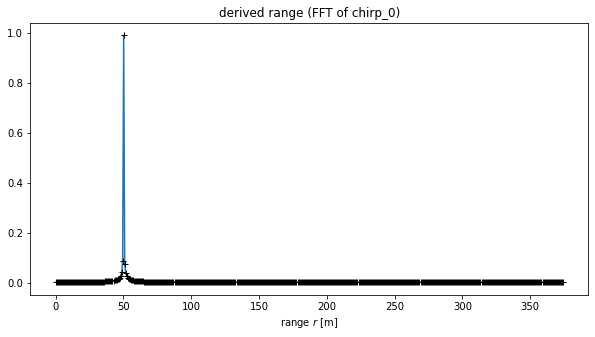

In [54]:
plt.figure(figsize=(10,5))
plt.plot(ranges, 2.0/n_s*np.abs(chirp0_magnitude[0:n_s//2]))
plt.plot(ranges, 2.0/n_s*np.abs(chirp0_magnitude[0:n_s//2]), "k+")
plt.xlabel("range $r$ [m]")
plt.title("derived range (FFT of chirp_0)")
print(freq_to_range(frequencies)[np.argmax(2.0/n_s*np.abs(chirp0_magnitude[0:n_s//2]))])

Looks like we got the distance right: $\approx 50m$

# Calculate range bins for each chirp

Now we do the same for each of $n_r$ chirps and save the FFT results in a table of shape $n_r × n_s/2$.

In [56]:
range_table = np.zeros((n_r, n_s//2), dtype=np.csingle)

In [57]:
for chirp_nr in range(n_r):
    chirp_ad_values = table_df.iloc[chirp_nr].values
    chirp_fft = fft(chirp_ad_values) # FFT
    range_table[chirp_nr, :] = 2.0/n_s*chirp_fft[:n_s//2]

Let's visualize the table

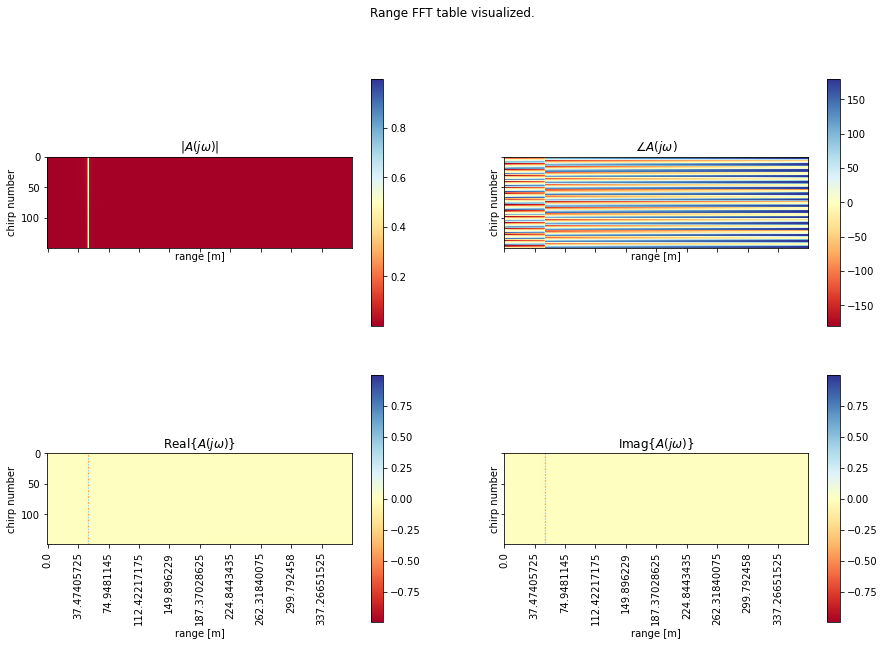

In [60]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10), sharex=True, sharey=True)
abs_axes = ax[0, 0]
phi_axes = ax[0, 1]
real_axes = ax[1, 0]
imag_axes = ax[1, 1]

im_asb = abs_axes.imshow(np.abs(range_table), cmap = plt.get_cmap('RdYlBu'))
abs_axes.set_xticks(range(ranges.size)[::50])
abs_axes.set_xticklabels(ranges[::50], rotation=90)
fig.colorbar(im_asb, ax=abs_axes)
abs_axes.set_xlabel("range [m]")
abs_axes.set_ylabel("chirp number")
abs_axes.set_title("$|A(j\omega)|$")

im_phi = phi_axes.imshow(np.angle(range_table)*360/(2*np.pi), cmap = plt.get_cmap('RdYlBu'))
fig.colorbar(im_phi, ax=phi_axes)
phi_axes.set_xlabel("range [m]")
phi_axes.set_ylabel("chirp number")
phi_axes.set_title("$∠ A(j\omega)$")
phi_axes.set_xticks(range(ranges.size)[::50])
phi_axes.set_xticklabels(ranges[::50], rotation=90)

im_real = real_axes.imshow(np.real(range_table), cmap = plt.get_cmap('RdYlBu'))
fig.colorbar(im_real, ax=real_axes)
real_axes.set_xlabel("range [m]")
real_axes.set_ylabel("chirp number")
real_axes.set_title("Real{$A(j\omega)$}")
real_axes.set_xticks(range(ranges.size)[::50])
real_axes.set_xticklabels(ranges[::50], rotation=90)

im_imag = imag_axes.imshow(np.imag(range_table), cmap = plt.get_cmap('RdYlBu'))
fig.colorbar(im_imag, ax=imag_axes)
imag_axes.set_xlabel("range [m]")
imag_axes.set_ylabel("chirp number")
imag_axes.set_title("Imag{$A(j\omega)$}");
imag_axes.set_xticks(range(ranges.size)[::50])
imag_axes.set_xticklabels(ranges[::50], rotation=90);

fig.suptitle("Range FFT table visualized.");

## Velocity estimation

We make a second FFT over each range bin (column).

Again, we initialize an empty table. Now the rows will be different velocity ranges.

In [61]:
velocity_table = np.zeros((n_r, range_table.shape[1]), dtype=np.csingle)

In [62]:
for r in range(range_table.shape[1]):
    range_bin_magn = range_table[:, r]
    range_bin_fft = fft(range_bin_magn)
    velocity_table[:, r]= 2.0/n_r*range_bin_fft

Second FFT on columns returns the phase shift

\begin{align}
... + \frac{4 \pi f_0 }{c} r = ... + \frac{4 \pi f_0 }{c} vt \\
\Rightarrow \frac{4 \pi f_0 }{c}v = \omega_{\text{FFT, columns}}
\end{align}

After rearranging ...

In [63]:
def angle_freq_to_velocity(w):
    return w*c/(4*np.pi*f_0)

In [64]:
omega_second = 2*np.pi*np.concatenate((np.arange(0, n_r//2), np.arange(-n_r//2, 0)[::-1]))*f_chirp/n_r

In [65]:
velocities = angle_freq_to_velocity(omega_second)

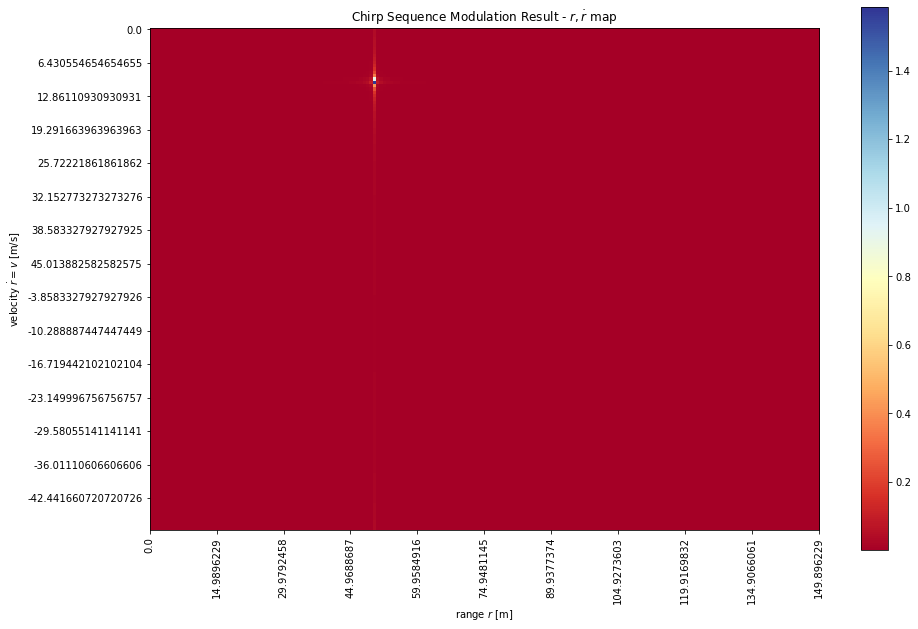

In [66]:
plt.figure(figsize=(15,10))
plt.imshow(np.abs(velocity_table), cmap = plt.get_cmap('RdYlBu'))
plt.xticks(range(ranges.size)[::20], ranges[::20], rotation=90);
plt.yticks(range(velocities.size)[::10], velocities[::10]);
plt.xlim([0, 200])
plt.xlabel("range $r$ [m]")
plt.ylabel("velocity $\\dot r = v$ [m/s]");
plt.title("Chirp Sequence Modulation Result - $r, \\dot r$ map")
plt.colorbar();

As you can see, we could successfully recognize (blue dot) the target in 50m range with velocity of $10 m/s$.